# Impact of the geometry on HPL performance

In [1]:
import io
import zipfile
import os
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import yaml
import warnings
warnings.simplefilter(action='ignore') # removing annoying Pandas warning

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

def get_platform(archive_name):
    info = get_yaml(archive_name, 'info.yaml')
    expfiles = info['expfile']
    platform = [f for f in expfiles if f.endswith('xml')]
    assert len(platform) == 1
    return platform[0]

def read_result(name):
    archive = zipfile.ZipFile(name)
    df = pandas.read_csv(io.BytesIO(archive.read('results.csv')))
    df['filename'] = name
    return df

directory = 'geometry/2'
archives = [os.path.join(directory, f) for f in os.listdir(directory)]

df = pandas.concat([read_result(a) for a in archives])
df['geometry'] = df['proc_p'].astype(str) + '×' + df['proc_q'].astype(str)
df.head()

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process,time,gflops,residual,start_timestamp,stop_timestamp,filename,geometry
0,100000,512,8,120,1,2,2,1,0,8,32,1,65.27,10210.0,0.001677,2020-06-17 10:46:08.486502,2020-06-17 10:47:16.217971,geometry/2/grenoble_2020-06-17_1936113.zip,8×120
1,100000,512,6,160,1,2,2,1,0,8,32,1,76.14,8756.0,0.001702,2020-06-17 10:47:17.022966,2020-06-17 10:48:35.927010,geometry/2/grenoble_2020-06-17_1936113.zip,6×160
2,200000,512,4,240,1,2,2,1,0,8,32,1,479.22,11130.0,0.001895,2020-06-17 10:48:37.925564,2020-06-17 10:56:42.298650,geometry/2/grenoble_2020-06-17_1936113.zip,4×240
3,200000,512,8,120,1,2,2,1,0,8,32,1,360.57,14790.0,0.001596,2020-06-17 10:56:44.296428,2020-06-17 11:02:49.853592,geometry/2/grenoble_2020-06-17_1936113.zip,8×120
4,100000,512,24,40,1,2,2,1,0,8,32,1,49.17,13560.0,0.001206,2020-06-17 11:02:51.886567,2020-06-17 11:03:43.406539,geometry/2/grenoble_2020-06-17_1936113.zip,24×40


### Checking the parameters

In [2]:
name_exceptions = {'application_time', 'simulation_time', 'usr_time', 'sys_time', 'time', 'gflops', 'residual', 'cpu_utilization',
                   'dgemm_coefficient', 'dgemm_intercept', 'dtrsm_coefficient', 'dtrsm_intercept',
                   'stochastic_cpu', 'polynomial_dgemm', 'stochastic_network', 'heterogeneous_dgemm', 'platform', 'model', 'filename',
                   'simulation', 'slow_nodes',
                   'major_page_fault', 'minor_page_fault', 'matrix_size', 'mode',
                   'start_timestamp', 'stop_timestamp'}
colnames = set(df) - name_exceptions
df[list(colnames)].drop_duplicates()

,proc_p,block_size,thread_per_process,swap,geometry,rfact,bcast,pfact,process_per_node,mem_align,depth,proc_q
0,8,512,1,0,8×120,2,2,1,32,8,1,120
1,6,512,1,0,6×160,2,2,1,32,8,1,160
2,4,512,1,0,4×240,2,2,1,32,8,1,240
4,24,512,1,0,24×40,2,2,1,32,8,1,40
6,3,512,1,0,3×320,2,2,1,32,8,1,320
8,5,512,1,0,5×192,2,2,1,32,8,1,192
10,12,512,1,0,12×80,2,2,1,32,8,1,80
11,2,512,1,0,2×480,2,2,1,32,8,1,480
12,16,512,1,0,16×60,2,2,1,32,8,1,60
13,30,512,1,0,30×32,2,2,1,32,8,1,32


## HPL performance

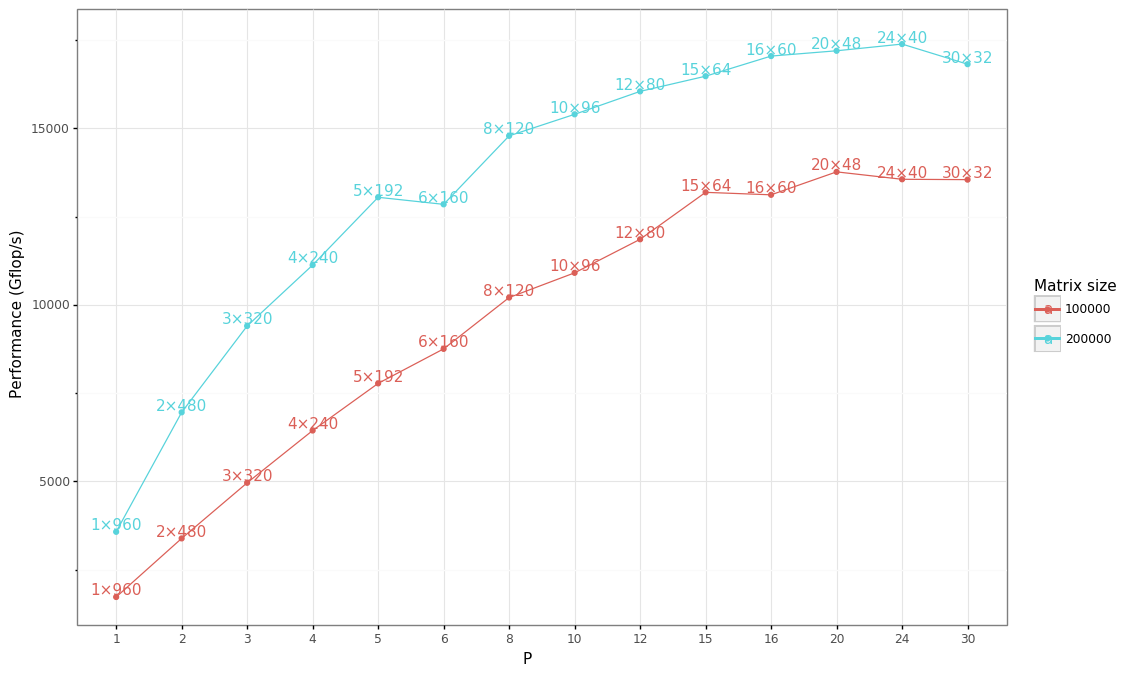

<ggplot: (-9223363243915467772)>

In [3]:
df['group'] = df['filename'] + ':' + df['matrix_size'].astype(str)
(ggplot(df)
    + aes(x='factor(proc_p)', y='gflops', color='factor(matrix_size)', group='group')
    + geom_point()
    + geom_text(aes(label='geometry'), position=position_nudge(y=200))
    + geom_line()
    + theme_bw()
    + labs(x='P', y='Performance (Gflop/s)', color='Matrix size')
)